In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None

data = pd.read_csv('unseen_species_model/unseen_species_model_bayesian.csv', index_col = [0])
data = data[['individual_wikidata_id', 'occupation', 'decade', 'f0', 'region_name']]

keep_list = ['Arabic world',
 'Central Europe',
 'Chinese world',
 'France',
 'German world',
 'Greek World',
 'Indian world',
 'Italy',
 'Japan',
 'Korea',
 'Latin World',
 'Low countries',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'Spain',
 'United Kingdom']

data = data[data['region_name'].isin(keep_list)]

data = data[~((data['region_name'] == "Arabic world") & (data['decade'] < 700))]

duplicates = data[data.duplicated(subset=['individual_wikidata_id'], keep=False)]
duplicates

data = data.sample(n=len(data), random_state=42)

# Remove duplicates by keeping the first occurrence of each individual_wikidata_id
data = data.drop_duplicates(subset=['individual_wikidata_id'], keep='first')

df = pd.read_csv('unseen_species_model/individuals_into_unseen_plus_>3.csv', index_col = [0])
df["count"] = df["count_works"]

df = df[['individual_wikidata_id', 'count_works', 'occupation', 'region_name']].drop_duplicates()
df = df[df['region_name'].isin(keep_list)]
df = df.sample(n=len(df), random_state=42)

# Remove duplicates by keeping the first occurrence of each individual_wikidata_id
df = df.drop_duplicates(subset=['individual_wikidata_id'], keep='first')
df = df.reset_index(drop=True)
df

def categorize_works(count):
    if count <= 1:
        return 'f1'
    elif count == 2:
        return 'f2'
    else:  # count > 2
        return 'f>2'

# Add a new column for the category
df['works_category'] = df['count_works'].apply(categorize_works)
df['works_category'].value_counts()


works_category
f1     99864
f>2    17769
f2      5001
Name: count, dtype: int64

In [6]:
# Set pandas display options to show full numbers
pd.set_option('display.float_format', '{:.6f}'.format)

# Define a function to perform the analysis for a given column
def analyze_column(data, df, group_column):
    # Calculate sum of f0 by group
    data_grouped = data.groupby(group_column)['f0'].sum().reset_index()
    
    # # Use rounding instead of truncation when converting to int
    #data_grouped['f0'] = data_grouped['f0'].round().astype(int)

    # data_grouped['f0'] = round(data_grouped['f0'], 1)
    # data_grouped['f0'] = data_grouped['f0'].astype(int)

    
    # Print the total f0 for verification
    print(f"Total f0 for {group_column} after rounding: {data_grouped['f0'].sum()}")
    
    # Make a copy of df for this analysis
    df_copy = df.copy()
    
    # Add category column for works
    def categorize_works(count):
        if count <= 1:
            return 'f1'
        elif count == 2:
            return 'f2'
        else:  # count > 2
            return 'f>2'
    
    # Add category column
    df_copy['works_category'] = df_copy['count_works'].apply(categorize_works)
    
    # Group by the column and works_category, then count
    grouped = df_copy.groupby([group_column, 'works_category']).size()
    
    # Reshape to have group as rows and categories as columns
    result = grouped.unstack(fill_value=0)
    
    # Reset index to make the group column a regular column
    result = result.reset_index()
    
    # Merge the two dataframes
    merged_df = pd.merge(data_grouped, result, on=group_column, how='left')
    
    # Create a modified count_works column where 0 is replaced with 1
    df_copy['adjusted_works'] = df_copy['count_works'].apply(lambda x: 1 if x == 0 else x)
    
    # Group by the column and sum the adjusted works
    works_by_group = df_copy.groupby(group_column)['adjusted_works'].sum().reset_index()
    works_by_group.rename(columns={'adjusted_works': 'total_works'}, inplace=True)
    
    # Merge works count with the existing dataframe
    final_df = pd.merge(merged_df, works_by_group, on=group_column, how='left')
    
    # Convert total_works to integer with rounding
    final_df['total_works'] = final_df['total_works'].round().astype(int)
    
    # Calculate 'Observed' column (sum of f1, f2, f>2)
    final_df['Observed (f1, f2, f>2)'] = final_df['f1'] + final_df['f2'] + final_df['f>2']
    
    # Rename f0 column for clarity
    final_df = final_df.rename(columns={'f0': 'f0 ("unseen species")'})
    
    # Calculate 'Estimated' column (sum of f0, f1, f2, f>2)
    final_df['Estimated (f0, f1, f2, f>2)'] = final_df['f0 ("unseen species")'] + final_df['Observed (f1, f2, f>2)']
    
    # Calculate 'Detection ratio'
    final_df['Detection ratio (Observed/Estimated)'] = final_df['Observed (f1, f2, f>2)'] / final_df['Estimated (f0, f1, f2, f>2)']
    
    # Calculate 'coverage'
    final_df['coverage (f1/n_works)'] = final_df['f1'] / final_df['total_works']
    
    # Select and reorder columns
    column_order = [
        group_column,
        'f1',
        'f2',
        'f>2',
        'Observed (f1, f2, f>2)',
        'f0 ("unseen species")',
        'Estimated (f0, f1, f2, f>2)',
        'Detection ratio (Observed/Estimated)',
        'total_works',
        'coverage (f1/n_works)'
    ]
    final_df = final_df[column_order]
    
    # Add total row
    totals = pd.Series({
        group_column: 'Total',
        'f1': final_df['f1'].sum(),
        'f2': final_df['f2'].sum(),
        'f>2': final_df['f>2'].sum(),
        'Observed (f1, f2, f>2)': final_df['Observed (f1, f2, f>2)'].sum(),
        'f0 ("unseen species")': final_df['f0 ("unseen species")'].sum(),
        'Estimated (f0, f1, f2, f>2)': final_df['Estimated (f0, f1, f2, f>2)'].sum(),
        'total_works': final_df['total_works'].sum(),
    })
    
    # Calculate overall ratios for the total row
    totals['Detection ratio (Observed/Estimated)'] = totals['Observed (f1, f2, f>2)'] / totals['Estimated (f0, f1, f2, f>2)']
    totals['coverage (f1/n_works)'] = totals['f1'] / totals['total_works']
    
    # Convert totals to DataFrame and add to final_df
    final_df_with_totals = pd.concat([final_df, pd.DataFrame([totals])], ignore_index=True)
    
    # Format the ratio columns as percentages
    final_df_with_totals['Detection ratio (Observed/Estimated)'] = final_df_with_totals['Detection ratio (Observed/Estimated)'].map('{:.2%}'.format)
    final_df_with_totals['coverage (f1/n_works)'] = final_df_with_totals['coverage (f1/n_works)'].map('{:.2%}'.format)
    
    return final_df_with_totals

# Check for missing values
print("Missing values in data:")
print(data[['region_name', 'occupation', 'f0']].isna().sum())

# Use the same cleaned dataset for both analyses
data_clean = data.copy()
df_clean = df.copy()

# Print total sum before any operations
print(f"Total f0 sum before any operations: {data_clean['f0'].sum()}")

# Loop through the columns you want to analyze
columns_to_analyze = ['occupation', 'region_name']
results = {}

for column in columns_to_analyze:
    results[column] = analyze_column(data_clean, df_clean, column)
  

results['region_name']['f0 ("unseen species")'] = round(results['region_name']['f0 ("unseen species")'], 0)
results['occupation']['f0 ("unseen species")'] = round(results['occupation']['f0 ("unseen species")'], 0)

results['region_name']['f0 ("unseen species")'] = results['region_name']['f0 ("unseen species")'].astype(int)
results['occupation']['f0 ("unseen species")'] = results['occupation']['f0 ("unseen species")'].astype(int)


var = 'Estimated (f0, f1, f2, f>2)'
results['region_name'][var] = round(results['region_name'][var], 0)
results['occupation'][var] = round(results['occupation'][var], 0)

results['region_name'][var] = results['region_name'][var].astype(int)
results['occupation'][var] = results['occupation'][var].astype(int)


Missing values in data:
region_name    0
occupation     0
f0             0
dtype: int64
Total f0 sum before any operations: 2491293.6556456336
Total f0 for occupation after rounding: 2491293.655645634
Total f0 for region_name after rounding: 2491293.655645634


In [7]:
results['occupation']

,occupation,f1,f2,f>2,"Observed (f1, f2, f>2)","f0 (""unseen species"")","Estimated (f0, f1, f2, f>2)",Detection ratio (Observed/Estimated),total_works,coverage (f1/n_works)
0,Architect,6973,138,307,7418,195002,202420,3.66%,13806,50.51%
1,Musician,14185,82,163,14430,1393894,1408324,1.02%,17597,80.61%
2,Painter,21006,2276,9925,33207,106760,139967,23.72%,312171,6.73%
3,Performing Artist,3008,110,363,3481,44330,47811,7.28%,18304,16.43%
4,Sculptor,6361,475,1690,8526,47460,55986,15.23%,51644,12.32%
5,Writer,48331,1920,5321,55572,703848,759420,7.32%,313879,15.40%
6,Total,99864,5001,17769,122634,2491294,2613928,4.69%,727401,13.73%


In [8]:
results['region_name']

,region_name,f1,f2,f>2,"Observed (f1, f2, f>2)","f0 (""unseen species"")","Estimated (f0, f1, f2, f>2)",Detection ratio (Observed/Estimated),total_works,coverage (f1/n_works)
0,Arabic world,1041,71,229,1341,9814,11155,12.02%,26651,3.91%
1,Central Europe,8293,205,781,9279,335099,344378,2.69%,28836,28.76%
2,Chinese world,1375,124,519,2018,10605,12623,15.99%,52929,2.60%
3,France,16709,1121,3587,21417,264692,286109,7.49%,128060,13.05%
4,German world,28370,957,2872,32199,932397,964596,3.34%,101398,27.98%
5,Greek World,968,54,120,1142,14033,15175,7.53%,5792,16.71%
6,Indian world,378,33,80,491,3462,3953,12.42%,1520,24.87%
7,Italy,13660,554,1988,16202,411813,428015,3.79%,63109,21.65%
8,Japan,885,63,232,1180,8482,9662,12.21%,6685,13.24%
9,Korea,169,10,3,182,1894,2076,8.77%,254,66.54%


### Graph for Survival Ratio for Occupations

In [9]:
import pandas as pd
pd.options.mode.chained_assignment = None

data = pd.read_csv('unseen_species_model/unseen_species_model_bayesian.csv', index_col = [0])
data_occupation = data[['individual_wikidata_id', 'occupation', 'decade', 'min_f0', 'f0', 'max_f0', 'region_name']]

keep_list = ['Arabic world',
 'Central Europe',
 'Chinese world',
 'France',
 'German world',
 'Greek World',
 'Indian world',
 'Italy',
 'Japan',
 'Korea',
 'Latin World',
 'Low countries',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'Spain',
 'United Kingdom']


data_occupation = data_occupation[data_occupation['region_name'].isin(keep_list)]
data_occupation = data_occupation.groupby(['occupation']).agg({'f0':'sum', 'min_f0':'sum', 'max_f0':'sum'}).reset_index()


df_occupation = df[df['region_name'].isin(keep_list)]
df_occupation = df_occupation[['individual_wikidata_id','occupation']]
df_occupation = df_occupation.groupby(['occupation']).agg({'individual_wikidata_id':'count'}).reset_index()

final_df = pd.merge(data_occupation, df_occupation, on = 'occupation')
final_df['total_f0'] = final_df['f0'] +final_df['individual_wikidata_id']
final_df['total_min_f0'] = final_df['min_f0'] +final_df['individual_wikidata_id']
final_df['total_max_f0'] = final_df['max_f0'] +final_df['individual_wikidata_id']


final_df['ratio'] = final_df['individual_wikidata_id']/final_df['total_f0']
final_df['ratio_max'] = final_df['individual_wikidata_id']/final_df['total_min_f0']
final_df['ratio_min'] = final_df['individual_wikidata_id']/final_df['total_max_f0']
final_df = final_df[['occupation', 'ratio_min', 'ratio', 'ratio_max']]



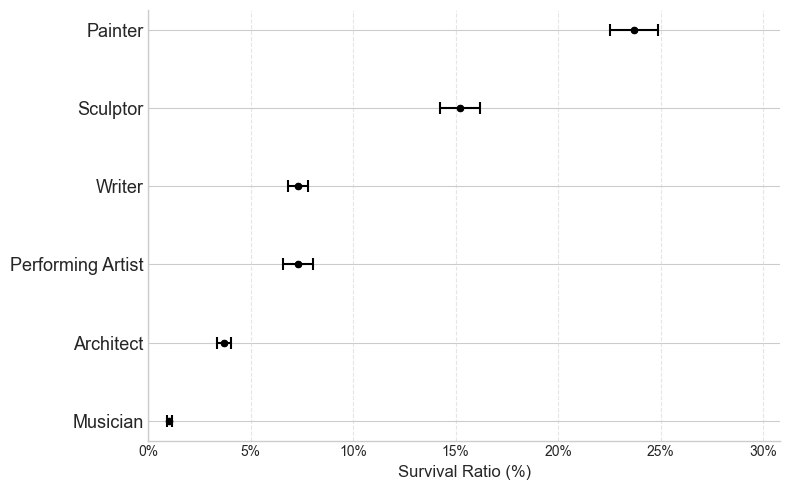

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.options.mode.chained_assignment = None

# Assuming you have already loaded and processed the data as in your code
# Here I'm starting from the final_df calculation

# Calculate error bars
final_df['lower_error'] = final_df['ratio'] - final_df['ratio_min']
final_df['upper_error'] = final_df['ratio_max'] - final_df['ratio']

# Sort data by ratio for better visualization
final_df = final_df.sort_values('ratio', ascending=True)

# Create the figure with a scientific style
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the forest plot with smaller points
y_pos = np.arange(len(final_df))
plt.errorbar(
    final_df['ratio'] * 100,  # Convert to percentage
    y_pos,
    xerr=[final_df['lower_error'] * 100, final_df['upper_error'] * 100],  # Convert errors to percentage
    fmt='o',
    capsize=4,
    capthick=1.5,
    markersize=4,  # Much smaller points
    markeredgecolor='black',
    ecolor='black',
    linewidth=1.5
)

# Use consistent color for all points to focus on the confidence intervals
plt.scatter(final_df['ratio'] * 100, y_pos, color='black', s=20, zorder=3)  # Convert to percentage

# Add region labels
plt.yticks(y_pos, final_df['occupation'], fontsize=13)

# Customize the plot
plt.xlabel('Survival Ratio (%)', fontsize=12)  # Updated label to indicate percentage
plt.title('', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.2)

# Add subtle grid lines
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

# Set x-axis range
plt.xlim(0, max(final_df['ratio']) * 100 * 1.3)  # Convert to percentage

# Format x-axis to show percentage
from matplotlib.ticker import PercentFormatter
plt.gca().xaxis.set_major_formatter(PercentFormatter(100, decimals=0))  # No decimal places

# Clean up the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ensure tight layout
plt.tight_layout()

# Save the plot as a high-resolution image

# Display the plot
plt.show()

### Graph for Survival Ratio for regions

In [11]:
import pandas as pd
pd.options.mode.chained_assignment = None

data = pd.read_csv('unseen_species_model/unseen_species_model_bayesian.csv', index_col = [0])
data_occupation = data[['individual_wikidata_id', 'occupation', 'decade', 'min_f0', 'f0', 'max_f0', 'region_name']]

keep_list = ['Arabic world',
 'Central Europe',
 'Chinese world',
 'France',
 'German world',
 'Greek World',
 'Indian world',
 'Italy',
 'Japan',
 'Korea',
 'Latin World',
 'Low countries',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'Spain',
 'United Kingdom']


data_occupation = data_occupation[data_occupation['region_name'].isin(keep_list)]
data_occupation = data_occupation.groupby(['region_name']).agg({'f0':'sum', 'min_f0':'sum', 'max_f0':'sum'}).reset_index()

df_occupation = df[df['region_name'].isin(keep_list)]
df_occupation = df_occupation[['individual_wikidata_id','region_name']]
df_occupation = df_occupation.groupby(['region_name']).agg({'individual_wikidata_id':'count'}).reset_index()

final_df = pd.merge(data_occupation, df_occupation, on = 'region_name')
final_df['total_f0'] = final_df['f0'] +final_df['individual_wikidata_id']
final_df['total_min_f0'] = final_df['min_f0'] +final_df['individual_wikidata_id']
final_df['total_max_f0'] = final_df['max_f0'] +final_df['individual_wikidata_id']


final_df['ratio'] = final_df['individual_wikidata_id']/final_df['total_f0']
final_df['ratio_max'] = final_df['individual_wikidata_id']/final_df['total_min_f0']
final_df['ratio_min'] = final_df['individual_wikidata_id']/final_df['total_max_f0']
final_df = final_df[['region_name', 'ratio_min', 'ratio', 'ratio_max']]



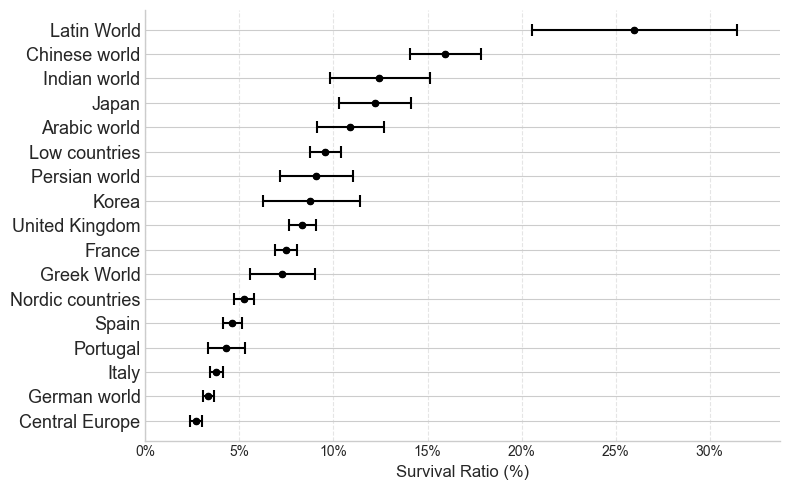

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.options.mode.chained_assignment = None

# Assuming you have already loaded and processed the data as in your code
# Here I'm starting from the final_df calculation

# Calculate error bars
final_df['lower_error'] = final_df['ratio'] - final_df['ratio_min']
final_df['upper_error'] = final_df['ratio_max'] - final_df['ratio']

# Sort data by ratio for better visualization
final_df = final_df.sort_values('ratio', ascending=True)

# Create the figure with a scientific style
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the forest plot with smaller points
y_pos = np.arange(len(final_df))
plt.errorbar(
    final_df['ratio'] * 100,  # Convert to percentage
    y_pos,
    xerr=[final_df['lower_error'] * 100, final_df['upper_error'] * 100],  # Convert errors to percentage
    fmt='o',
    capsize=4,
    capthick=1.5,
    markersize=4,  # Much smaller points
    markeredgecolor='black',
    ecolor='black',
    linewidth=1.5
)

# Use consistent color for all points to focus on the confidence intervals
plt.scatter(final_df['ratio'] * 100, y_pos, color='black', s=20, zorder=3)  # Convert to percentage

# Add region labels
plt.yticks(y_pos, final_df['region_name'], fontsize=13)

# Customize the plot
plt.xlabel('Survival Ratio (%)', fontsize=12)  # Updated label to indicate percentage
plt.title('', fontsize=13)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.2)

# Add subtle grid lines
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

# Set x-axis range
plt.xlim(0, max(final_df['ratio']) * 100 * 1.3)  # Convert to percentage

# Format x-axis to show percentage
from matplotlib.ticker import PercentFormatter
plt.gca().xaxis.set_major_formatter(PercentFormatter(100, decimals=0))  # No decimal places

# Clean up the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ensure tight layout
plt.tight_layout()

# Save the plot as a high-resolution image

# Display the plot
plt.show()